In [40]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, Concatenate, Dropout
from tensorflow.keras.models import Model


## Preprocessing the dataset for Neural Network model:

In [11]:
#Load the dataset and create a dictionary to map user and product IDs to unique integer values
data = pd.read_csv('filtered_data.csv')
users = data['userId'].unique()
user_id_to_int = {user_id: i for i, user_id in enumerate(users)}

products = data['productId'].unique()
product_id_to_int = {product_id: i for i, product_id in enumerate(products)}


In [12]:
#Replace user and product IDs in the dataset with their corresponding integer values:
data['userId'] = data['userId'].apply(lambda x: user_id_to_int[x])
data['productId'] = data['productId'].apply(lambda x: product_id_to_int[x])


In [21]:
#Normalize the timestamp by subtracting the user's first ever review time:
data['timestamp'] = data.groupby('userId')['timestamp'].apply(lambda x: x - x.min())
data.head()
data = data.sample(frac=0.1, random_state=42)

In [22]:
#Split the dataset into training and testing sets
train_df, val_df = train_test_split(data, test_size=0.2, random_state=42)

In [23]:
from sklearn.preprocessing import MinMaxScaler

# Scale 'timestamp' to be between 0 and 1
scaler = MinMaxScaler()
train_df['timestamp'] = scaler.fit_transform(train_df['timestamp'].values.reshape(-1, 1))
val_df['timestamp'] = scaler.transform(val_df['timestamp'].values.reshape(-1, 1))

# Split the data into input and output variables
train_data = train_df.drop('rating', axis=1).values
train_labels = train_df['rating'].values
val_data = val_df.drop('rating', axis=1).values
val_labels = val_df['rating'].values

# Reshape the input variables
train_data = train_data.reshape((train_data.shape[0], train_data.shape[1], 1))
val_data = val_data.reshape((val_data.shape[0], val_data.shape[1], 1))


/home/ec2-user/anaconda3/envs/amazonei_tensorflow2_p36/lib/python3.6/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ec2-user/anaconda3/envs/amazonei_tensorflow2_p36/lib/python3.6/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


## Define and train the model: 

In [45]:
# Define the inputs
user_id_input = Input(shape=[1], name='user')
product_id_input = Input(shape=[1], name='product')

# User embedding
user_embedding = Embedding(input_dim=len(users), output_dim=64, input_length=1, name='user_embedding')(user_id_input)
user_flattened = Flatten()(user_embedding)

# Product embedding
product_embedding = Embedding(input_dim=len(products), output_dim=64, input_length=1, name='product_embedding')(product_id_input)
product_flattened = Flatten()(product_embedding)

# Concatenate the user and product embeddings
x = Concatenate()([user_flattened, product_flattened])

# Add fully connected layers
x = Dense(64, activation='relu')(x)
x = Dense(32, activation='relu')(x)

# Output layer with a single neuron
output = Dense(1)(x)

# Define the model
model = Model(inputs=[user_id_input, product_id_input], outputs=output)

# Compile the model
model.compile(loss='mse', optimizer='adam', metrics=['mae'])

# Train the model
history = model.fit(x=[train_df['userId'], train_df['productId']], y=train_df['rating'],
                    batch_size=128, epochs=10, validation_data=([val_df['userId'], val_df['productId']], val_df['rating']))

# Save the trained model
model.save('amazon_reviews_nn_model.h5')

Epoch 1/10
1245/1245 [==============================] - 190s 152ms/step - loss: 2.1126 - mae: 1.0693 - val_loss: 1.3936 - val_mae: 0.9077
Epoch 2/10
1245/1245 [==============================] - 190s 152ms/step - loss: 0.8891 - mae: 0.6671 - val_loss: 1.5077 - val_mae: 0.9163
Epoch 3/10
1245/1245 [==============================] - 190s 152ms/step - loss: 0.4594 - mae: 0.4580 - val_loss: 1.7499 - val_mae: 1.0114
Epoch 4/10
1245/1245 [==============================] - 190s 152ms/step - loss: 0.2703 - mae: 0.3468 - val_loss: 1.8116 - val_mae: 1.0081
Epoch 5/10
1245/1245 [==============================] - 190s 153ms/step - loss: 0.1709 - mae: 0.2742 - val_loss: 1.7861 - val_mae: 1.0099
Epoch 6/10
1245/1245 [==============================] - 190s 153ms/step - loss: 0.1209 - mae: 0.2262 - val_loss: 1.8493 - val_mae: 1.0364
Epoch 7/10
1245/1245 [==============================] - 190s 153ms/step - loss: 0.0850 - mae: 0.1883 - val_loss: 1.8143 - val_mae: 1.0284
Epoch 8/10
1245/1245 [============

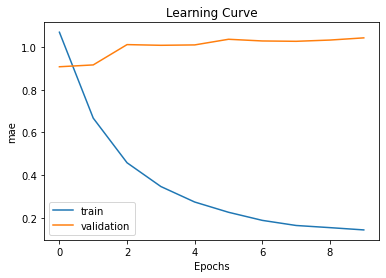

In [46]:
import matplotlib.pyplot as plt
#Print the learning curve for each Epoch
plt.plot(history.history['mae'], label='train')
plt.plot(history.history['val_mae'], label='validation')
plt.title('Learning Curve')
plt.xlabel('Epochs')
plt.ylabel('mae')
plt.legend()
plt.show()

## Evaluate the model:

In [47]:
# Load the saved model
from tensorflow.keras.models import load_model
model = load_model('amazon_reviews_nn_model.h5')

# Evaluate the model on the test data
test_loss, test_mae = model.evaluate([val_df['userId'], val_df['productId'], val_df['timestamp']], val_df['rating'])

# Print the test loss and test MAE
print('Test Loss:', test_loss)
print('Test MAE:', test_mae)

1245/1245 [==============================] - 1s 451us/step - loss: 1.8498 - mean_absolute_error: 1.0429
Test Loss: 1.84977388381958
Test MAE: 1.04292893409729
